# Causal Forest Estimation of Heterogenous Corruption Audit Effects

In [1]:
install.packages("grf")
library(grf)

Warning message in install.packages("grf"):
“installation of package ‘grf’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message:
“package ‘grf’ was built under R version 3.6.3”

In [2]:
install.packages("DiagrammeR")
library(DiagrammeR)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
install.packages("ggstance")
library(ggstance)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
install.packages("itertools")
library("itertools")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: iterators


In [5]:
install.packages("truncnorm")
install.packages("ggplot2")
install.packages("tmvtnorm")

library(truncnorm)

library(tmvtnorm)

library(foreign)
library(ggplot2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Warning message:
“package ‘sandwich’ was built under R version 3.6.3”
Attaching package: ‘ggplot2’

The following objects are masked from ‘package:ggstance’:

    GeomErrorbarh, geom_errorbarh



In [6]:
install.packages("MASS")
library(MASS)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [7]:
install.packages("lmtest")
library(lmtest)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [8]:
install.packages("grf")
library(grf)

Warning message in install.packages("grf"):
“installation of package ‘grf’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [9]:
randomization_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperandomizationdata.dta")
(road_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperoaddata.dta"))

merged_data<-merge(randomization_data, road_data, by="desaid")
merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)

X_cont=as.data.frame(cbind(merged_data$zpop, merged_data$totalmesjid, merged_data$totalallocation, merged_data$z4RABnumsubproj, merged_data$zpercentpoorpra, merged_data$zdistancekec,
        merged_data$zkadesedyears, merged_data$zkadesage, merged_data$zkadesbengkoktotal))


z7enumcode,audit,auditstratnum,und,fpm,undfpm,sd,lndiffeburuh,lndiffeall4,lndiffeall3mat,...,lndiffqtall4,lndiffpall4,totalprojusd,stdz13scorefisik,stdz13scoreadmin,stdz12scorefisikboth,stdz12scoreadminboth,kecnum,desaid,kecid
F23,0,11,0,0,0,0,0.80196363,0.38527447,0.37608007,...,0.330694944,0.051268794,4507.255,NA,NA,NA,NA,001,3301001001,3301001
F23,0,11,0,1,1,0,0.51758903,-0.09574836,-0.23895392,...,-0.025945611,-0.030868988,7702.855,NA,NA,NA,NA,001,3301001002,3301001
F23,0,11,1,0,1,0,1.59478140,0.14771932,-0.27322078,...,0.355605900,-0.021249659,4567.389,NA,NA,NA,NA,001,3301001003,3301001
F23,0,11,1,0,1,1,0.61145359,-0.18259121,-0.31239548,...,-0.082396172,-0.109253176,1896.686,NA,NA,NA,NA,001,3301001004,3301001
F23,0,11,0,0,0,0,0.57933968,-0.29304767,-0.39842680,...,-0.009104517,-0.217185318,8036.473,NA,NA,NA,NA,001,3301001005,3301001
F23,1,11,0,1,1,0,0.64566767,-0.09736358,-0.10423158,...,0.022496168,-0.122077160,7759.230,-0.20387749,-0.06129840,0.33622959,0.7783315,002,3301002001,3301002
F23,1,11,0,0,0,0,0.13024548,-0.12150725,-0.13674238,...,-0.016689623,-0.080888718,9257.103,-1.09297717,0.67032188,1.02781534,-0.1010358,002,3301002002,3301002
F23,1,11,0,1,1,1,0.26421076,0.11745975,0.09242168,...,0.098885514,0.065994464,6232.739,-0.84472221,-0.07182464,1.38177633,0.4973977,002,3301002003,3301002
F23,1,11,1,0,1,1,0.93529183,0.17976519,0.15495154,...,0.281060249,-0.164035439,6131.706,-1.98207688,-0.68220496,-0.01990974,-1.0321302,002,3301002004,3301002
F23,1,11,0,0,0,0,0.07041851,-0.05508656,-0.08923000,...,0.123631261,-0.247277439,6206.667,-2.38332677,-1.61344719,0.59761626,0.2259872,002,3301002005,3301002


In [75]:
data_generation<-function(N, model){

set.seed(1)
mu<-colMeans(X_cont, na.rm=TRUE)
sd<-apply(X_cont, 2, sd, na.rm=TRUE)

cov<-var(X_cont, na.rm=TRUE)

glm.fit<-glm(podeszhill ~ zpop+totalmesjid+totalallocation+z4RABnumsubproj+zpercentpoorpra+zdistancekec+zkadesedyears+zkadesage+zkadesbengkoktotal, data = merged_data, family = "binomial")



X_sim<-as.data.frame(rtmvnorm(n=N, mean = mu, sigma = cov, lower=rep(0,9), upper=c(rep(Inf,4), 1, rep(Inf,4))))

colnames(X_sim) <- c("zpop", "totalmesjid", "totalallocation", "z4RABnumsubproj", "zpercentpoorpra", "zdistancekec", "zkadesedyears", "zkadesage", "zkadesbengkoktotal")

#X_sim
mountainous<-c()
X_sim$mountainous<-predict(glm.fit,newdata=X_sim, type="response")
for (i in 1:nrow(X_sim)){
    X_sim$podeszhill[i]<-rbinom(n=1,size=1,prob=X_sim$mountainous[i])
    }
similarity_vars<-c("zpop", "totalmesjid", "totalallocation", "zpercentpoorpra", "podeszhill")

x_similarity<-as.data.frame(scale(X_sim[similarity_vars]))

for (i in 1:nrow(x_similarity)){
    x_similarity$similarity_score[i]<-sum(x_similarity[i,])+rnorm(n=1, sd=5, mean=0)
}

X_sim<-cbind(X_sim, "similscore"=x_similarity$similarity_score)
simulation_data<<-X_sim[order(X_sim$similscore),]



for (i in 1:nrow(simulation_data)){
   simulation_data$subdistrict[i]<-ceiling(i/(nrow(simulation_data)/150))
}



randomization_subdistricts<-rbinom(size=1, n=150, 0.48)
simulation_data$audit<-rep(randomization_subdistricts,each=nrow(simulation_data)/150)
    
if (model=='simple') {

simulation_data$lndiffeall4mainancil<-0.22-0.07*simulation_data$audit-
    0.017*simulation_data$zkadesbengkoktotal-
    0.016*simulation_data$audit*simulation_data$zkadesbengkoktotal+
    rnorm(nrow(simulation_data), mean=0, sd=0.03)
    
    simulation_data$tau<- -0.07-0.016*simulation_data$zkadesbengkoktotal
  
    
    
    linear_model<-lm(lndiffeall4mainancil~audit+totalallocation+zkadesbengkoktotal+audit*zkadesbengkoktotal, 
                     data=simulation_data)
    
    }
   
if (model=='medium') {
    
simulation_data$lndiffeall4mainancil<-0.27-0.09*simulation_data$audit+
    0.0001*simulation_data$totalallocation-
    0.0016*simulation_data$zkadesedyears+
    0.007*simulation_data$zkadesbengkoktotal+
    0.00000016*simulation_data$totalallocation^2-
    0.0002*simulation_data$zkadesbengkoktotal^2-
    0.01*simulation_data$audit*simulation_data$zkadesbengkoktotal-
    0.001*simulation_data$audit*simulation_data$totalallocation+
    0.0001*simulation_data$audit*simulation_data$totalallocation*simulation_data$zkadesbengkoktotal+
    0.000003*simulation_data$audit*(simulation_data$totalallocation^2)+
    0.0003*simulation_data$audit*simulation_data$zkadesbengkoktotal^2+             
    rnorm(nrow(simulation_data), mean=0, sd=0.01)
    
    simulation_data$tau<- -0.09-0.01*simulation_data$zkadesbengkoktotal-
    0.001*simulation_data$totalallocation+0.0001*simulation_data$totalallocation*
    simulation_data$zkadesbengkoktotal+0.000003*simulation_data$totalallocation^2+
    0.0003*simulation_data$zkadesbengkoktotal^2
    
                                                  
    }
    
if (model=='complex') {
    
    simulation_data$lndiffeall4mainancil<-0.5-0.05*simulation_data$audit-
    0.02*simulation_data$zpercentpoorpra-
    0.002*simulation_data$zpop-
    0.003*simulation_data$totalmesjid-
    0.0009*simulation_data$totalallocation+
    0.009*simulation_data$zkadesbengkoktotal-
    0.0002*(simulation_data$zkadesbengkoktotal)^2+
    0.0000009*(simulation_data$totalallocation)^2-
    0.3*simulation_data$audit*simulation_data$zpercentpoorpra-
    0.03*simulation_data$audit*simulation_data$zpop-
    0.003*simulation_data$audit*simulation_data$totalmesjid-
    0.002*simulation_data$audit*simulation_data$totalallocation-
    0.05*simulation_data$audit*simulation_data$zkadesbengkoktotal-
    0.001*(simulation_data$zkadesbengkoktotal)^2*simulation_data$audit+
    0.00001*(simulation_data$totalallocation)^2*simulation_data$audit-
    0.0000001*simulation_data$audit*simulation_data$totalallocation*simulation_data$zkadesbengkoktotal+
    rnorm(nrow(simulation_data), mean=0, sd=0.5)
    
    simulation_data$tau<- -0.05+0.3*simulation_data$zpercentpoorpra-
    0.03*simulation_data$zpop-
    0.003*simulation_data$totalmesjid-
    0.002*simulation_data$totalallocation-
    0.05*simulation_data$zkadesbengkoktotal-
    0.001*(simulation_data$zkadesbengkoktotal)^2+
    0.00001*(simulation_data$totalallocation)^2-
    0.0000001*simulation_data$totalallocation*simulation_data$zkadesbengkoktotal
    }
   
  
return(simulation_data)
}

#{
(Intercept)                                           5.3143e-01  2.3577e-01
audit.x                                              -1.5802e-02  3.5227e-01
zpercentpoorpra                                       2.4442e-01  1.9218e-01
zpop                                                  2.2063e-02  1.6587e-02
totalmesjid                                          -2.5208e-02  3.2118e-02
totalallocation                                       9.7908e-04  1.8246e-03
z4RABnumsubproj                                      -3.8968e-02  1.6794e-02
zdistancekec                                         -2.5885e-03  6.0762e-03
zkadesedyears                                        -8.0764e-03  8.7812e-03
zkadesage                                            -3.7880e-03  3.1181e-03
zkadesbengkoktotal                                    8.8701e-03  2.6310e-02
podeszhill                                           -5.0589e-02  5.6207e-02
I(totalallocation^2)                                 -8.6056e-07  6.8227e-06
I(zkadesbengkoktotal^2)                              -1.6561e-04  1.4061e-03
audit.x:zpercentpoorpra                              -3.3472e-01  2.9098e-01
audit.x:zpop                                         -2.8905e-02  2.3776e-02
zpercentpoorpra:zpop                                 -5.4060e-02  4.1737e-02
audit.x:totalmesjid                                  -3.3681e-03  4.2579e-02
audit.x:totalallocation                              -1.5961e-03  3.0325e-03
audit.x:z4RABnumsubproj                               1.3071e-02  3.0426e-02
audit.x:zdistancekec                                  1.4849e-03  7.9871e-03
audit.x:zkadesedyears                                 8.9696e-03  1.4009e-02
audit.x:zkadesage                                     1.5651e-03  4.0372e-03
audit.x:zkadesbengkoktotal                           -5.8040e-02  3.6432e-02
audit.x:podeszhill                                    2.3271e-02  7.6176e-02
totalallocation:zkadesbengkoktotal                   -8.8068e-05  3.3592e-04
audit.x:I(totalallocation^2)                          9.7596e-06  1.1480e-05
audit.x:I(zkadesbengkoktotal^2)                       1.2916e-03  1.5831e-03
I(totalallocation^2):I(zkadesbengkoktotal^2)          4.0755e-08  1.1168e-07
audit.x:zpercentpoorpra:zpop                          3.8149e-02  5.7637e-02
audit.x:totalallocation:zkadesbengkoktotal            6.2757e-04  4.5203e-04
audit.x:I(totalallocation^2):I(zkadesbengkoktotal^2) -1.3948e-07
    


#plot(get_tree(this$train_forest_honest,209))
#plot(get_tree(this$train_forest_adaptive,209))

plot(get_tree(this$train_forest_honest,209))
plot(get_tree(this$train_forest_adaptive,209))

In [70]:
MSE_function<-function(n_test, n_train, n.trees, model_est, model_true){
    
    MSE_honest<-list()
    MSE_adaptive<-list()
    coverage_honest<-list()
    coverage_adaptive<-list()
    
    simulation_data<-data_generation(N=n_train, model=model_true)
    X_train=cbind(simulation_data$totalallocation, simulation_data$zkadesbengkoktotal, simulation_data$zkadesedyears, simulation_data$totalmesjid, simulation_data$zpop, simulation_data$z4RABnumsubproj, simulation_data$zpercentpoorpra, simulation_data$zdistancekec, simulation_data$zkadesage)
    test_data<-data_generation(N=n_test, model=model_true)
    X_test<-cbind(test_data$totalallocation, test_data$zkadesbengkoktotal, test_data$zkadesedyears, test_data$totalmesjid, test_data$zpop, test_data$z4RABnumsubproj, test_data$zpercentpoorpra, test_data$zdistancekec, test_data$zkadesage)

    
    for (cluster in c('Yes', 'No')){
    
    if (cluster=='Yes')    { 
    train_forest_honest<-causal_forest(X_train, simulation_data$lndiffeall4mainancil, simulation_data$audit, W.hat=0.48, clusters=simulation_data$subdistricts, mtry=7, min.node.size=5, num.trees=n.trees)
    train_forest_adaptive<-causal_forest(X_train, simulation_data$lndiffeall4mainancil, simulation_data$audit, W.hat=0.48, mtry=7, clusters=simulation_data$subdistricts, min.node.size=5, honesty=FALSE, num.trees=n.trees)
    }
    
    if (cluster=='No') {
    train_forest_honest<-causal_forest(X_train, simulation_data$lndiffeall4mainancil, simulation_data$audit, W.hat=0.48,  mtry=7, min.node.size=5, num.trees=n.trees)
    train_forest_adaptive<-causal_forest(X_train, simulation_data$lndiffeall4mainancil, simulation_data$audit, W.hat=0.48, mtry=7,  min.node.size=5, honesty=FALSE, num.trees=n.trees)
    }
    
    if (model_est=='simple'){
        
    linear_model<-lm(lndiffeall4mainancil~totalallocation+audit*zkadesbengkoktotal, 
                     data=simulation_data)
    
    coefficients<-linear_model$coefficients
    
    tauhat_linear<-coefficients[3]+coefficients[5]*test_data$zkadesbengkoktotal
        
    }
    
    if (model_est=='medium'){
        
    linear_model<-lm(lndiffeall4mainancil~zkadesedyears+audit*zkadesbengkoktotal*totalallocation+audit*I(zkadesbengkoktotal^2)*I(totalallocation^2), 
                     data=simulation_data)
        
    coefficients<-linear_model$coefficients
        
    tauhat_linear<-coefficients[3]+
    coefficients[8]*test_data$zkadesbengkoktotal+
    coefficients[9]*test_data$totalallocation+
    coefficients[11]*test_data$zkadesbengkoktotal^2+
    coefficients[12]*test_data$totalallocation^2+    
    coefficients[13]*test_data$zkadesbengkoktotal*test_data$totalallocation  
    }

honest_predict<-predict(train_forest_honest, X_test, estimate.variance=TRUE)
adaptive_predict<-predict(train_forest_adaptive, X_test, estimate.variance=TRUE)

tauhat_honest<-honest_predict$predictions
tauhat_adaptive<-adaptive_predict$predictions
    
variance_honest<-honest_predict$variance.estimates
variance_adaptive<-adaptive_predict$variance.estimates
    
CI_honest_lower<-tauhat_honest-qnorm(0.95, mean=0, sd=1)*sqrt(variance_honest)
CI_honest_upper<-tauhat_honest+qnorm(0.95, mean=0, sd=1)*sqrt(variance_honest)
CI_adaptive_lower<-tauhat_adaptive-qnorm(0.95, mean=0, sd=1)*sqrt(variance_adaptive)
CI_adaptive_upper<-tauhat_adaptive+qnorm(0.95, mean=0, sd=1)*sqrt(variance_adaptive)

coverage_honest[[cluster]]<-mean(CI_honest_lower<=test_data$tau&test_data$tau<=CI_honest_upper)
coverage_adaptive[[cluster]]<-mean(CI_adaptive_lower<=test_data$tau&test_data$tau<=CI_adaptive_upper)


MSE_linear<-mean((test_data$tau-tauhat_linear)^2)
MSE_honest[[cluster]]<-mean((test_data$tau-tauhat_honest)^2)
MSE_adaptive[[cluster]]<-mean((test_data$tau-tauhat_adaptive)^2)

complete_data<-cbind(test_data, tauhat_honest, tauhat_linear)
}

return(list(MSE_linear=MSE_linear, MSE_honest=MSE_honest, MSE_adaptive=MSE_adaptive, coverage_honest=coverage_honest, coverage_adaptive=coverage_adaptive, complete_data=complete_data))
}

In [58]:
MSE_function(n_test=900, n_train=300, n.trees=20, model_true='medium', model_est='medium')

,zpop,totalmesjid,totalallocation,z4RABnumsubproj,zpercentpoorpra,zdistancekec,zkadesedyears,zkadesage,zkadesbengkoktotal,mountainous,podeszhill,similscore,subdistrict,audit,lndiffeall4mainancil,tau,tauhat_honest,tauhat_linear
576,6.83448817,0.40793379,63.323450,0.6136741,0.59252296,3.8757972,14.692538,49.44383,3.4833659,0.08482505,0,-20.91470,1,1,0.11826099,-0.1504295,-0.1373004,-0.1785252
84,3.08867341,1.57012962,86.909865,3.8299136,0.54552741,8.6325910,12.119872,36.79309,4.9641479,0.41818368,0,-19.78504,1,1,0.13526745,-0.1533552,-0.1428030,-0.2152869
195,2.41775207,1.22522448,55.507415,3.6972497,0.41848782,2.2565178,13.058431,39.29724,12.8893374,0.09283153,0,-19.61537,1,1,0.18830672,-0.1437717,-0.1401725,-0.2526716
532,1.53302030,0.21640088,67.078963,2.7629802,0.22684543,6.6439266,9.177516,44.58944,4.7066157,0.23190820,0,-18.98678,1,1,0.14251629,-0.1524292,-0.1436474,-0.1958027
799,8.91113115,1.30061327,133.710478,3.9070969,0.17695058,5.8776008,15.499860,40.88647,3.7145924,0.25044646,0,-18.50100,1,1,0.13221798,-0.1534135,-0.1535543,-0.2306327
674,3.22510519,0.75986232,60.515834,1.2131457,0.33037464,2.6536822,10.747831,49.84061,6.9173147,0.10496523,0,-18.40662,1,1,0.15858034,-0.1524870,-0.1304674,-0.2122683
219,1.92202365,0.43025736,37.396538,3.7689383,0.18862619,4.3786934,14.134112,24.44487,4.8289980,0.26830403,0,-18.34373,2,0,0.29728375,-0.1464365,-0.1463540,-0.1673717
793,7.87763520,0.49707612,78.806142,1.4600993,0.14561502,1.7384053,7.793298,41.69349,0.2424969,0.29768342,0,-18.20121,2,0,0.26635786,-0.1506712,-0.1307930,-0.1508752
538,3.80274969,2.33346958,6.344526,4.9973544,0.36226367,3.4924925,8.762552,51.60987,4.1810236,0.50349508,0,-18.08294,2,0,0.29650452,-0.1301371,-0.1448901,-0.1229585
583,3.71426689,2.67360103,38.211616,1.2147171,0.59991515,2.6327786,13.884797,33.41647,1.7189311,0.44640519,1,-17.78334,2,0,0.23776615,-0.1335658,-0.1297430,-0.1314678


In [78]:
mylist <- list()
MSE_df <- data.frame()
this<-matrix()
for (n in c(600, 300)){
for (model in c('simple', 'medium')){
    mylist[[sprintf("True model: %s. %s", model, n)]]<-MSE_function(n_test=900, n_train=n, n.trees=20, model_true=model, model_est=model)[1:5]
    MSE_df <- do.call("cbind",mylist)
  
}
}

In [79]:
MSE_df

,True model: simple. 600,True model: medium. 600,True model: simple. 300,True model: medium. 300
MSE_linear,4.056513e-06,0.004245689,1.551322e-06,0.004723331
MSE_honest,"0.0006687224, 0.0003714205","0.0002666825, 0.0003428112","0.0003213206, 0.0004576630","0.0004053038, 0.0003708851"
MSE_adaptive,"0.0005233598, 0.0006548522","0.0002040785, 0.0001905629","0.0003121255, 0.0003877760","0.0004117681, 0.0003416196"
coverage_honest,"0.7933333, 0.8611111","0.6833333, 0.5555556","0.8888889, 0.8388889","0.6322222, 0.4355556"
coverage_adaptive,"0.8755556, 0.8311111","0.8522222, 0.8422222","0.9011111, 0.9155556","0.7188889, 0.8000000"


In [ ]:
trees<-c(10, 20, 30, 50, 100, 500, 2000, 5000)
dataf<-data.frame(
trees=NA,
cluster=NA,
nocluster=NA)
#coverage_prob<-list()
for (i in index(trees)){
    element<-trees[i]
    coverage<-MSE_function(n_test=3000, n_train=6000, n.trees=element, model_true='simple', model_est='simple')$coverage_honest
    #coverage_prob[[i]]<-rbind(element, "cluster"=coverage[1],"nocluster"=coverage[2])
    #dataf <- do.call("cbind", data.frame(coverage_prob))
    dataf[i,"trees"]<-element
    dataf[i,"cluster"]<-coverage[1]
    dataf[i,"nocluster"]<-coverage[2]
    }

In [ ]:
dataf

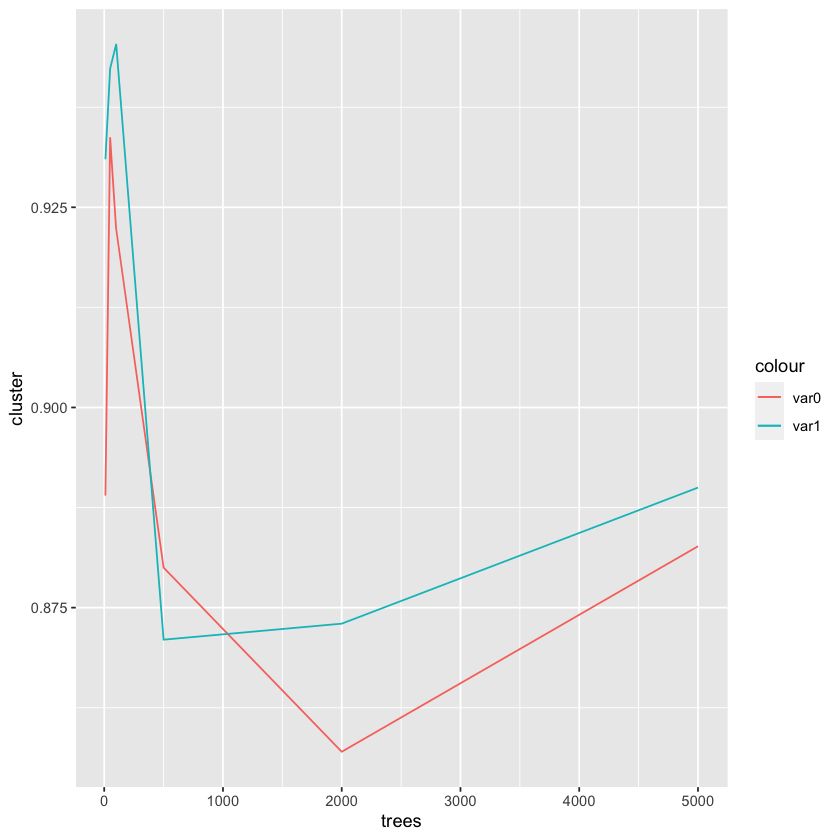

In [82]:
ggplot(dataf, aes(trees)) + 
  geom_line(aes(y = cluster, colour = "var0"))+
  geom_line(aes(y=nocluster, colour="var1"))

In [88]:
observations<-c(150, 300, 600, 900, 1200, 6000, 12000)
dataf<-data.frame(
observations=NA,
cluster=NA,
nocluster=NA)
#coverage_prob<-list()
for (i in index(observations)){
    element<-observations[i]
    coverage<-MSE_function(n_test=3000, n_train=element, n.trees=2000, model_true='simple', model_est='simple')$coverage_honest
    #coverage_prob[[i]]<-rbind(element, "cluster"=coverage[1],"nocluster"=coverage[2])
    #dataf <- do.call("cbind", data.frame(coverage_prob))
    dataf[i,"observations"]<-element
    dataf[i,"cluster"]<-coverage[1]
    dataf[i,"nocluster"]<-coverage[2]
    }


In [89]:
dataf

observations,cluster,nocluster
150,0.2823333,0.3240000
300,0.7460000,0.7153333
600,0.6580000,0.6456667
900,0.8023333,0.7946667
1200,0.7876667,0.7800000
6000,0.8876667,0.8803333
12000,0.9116667,0.9083333


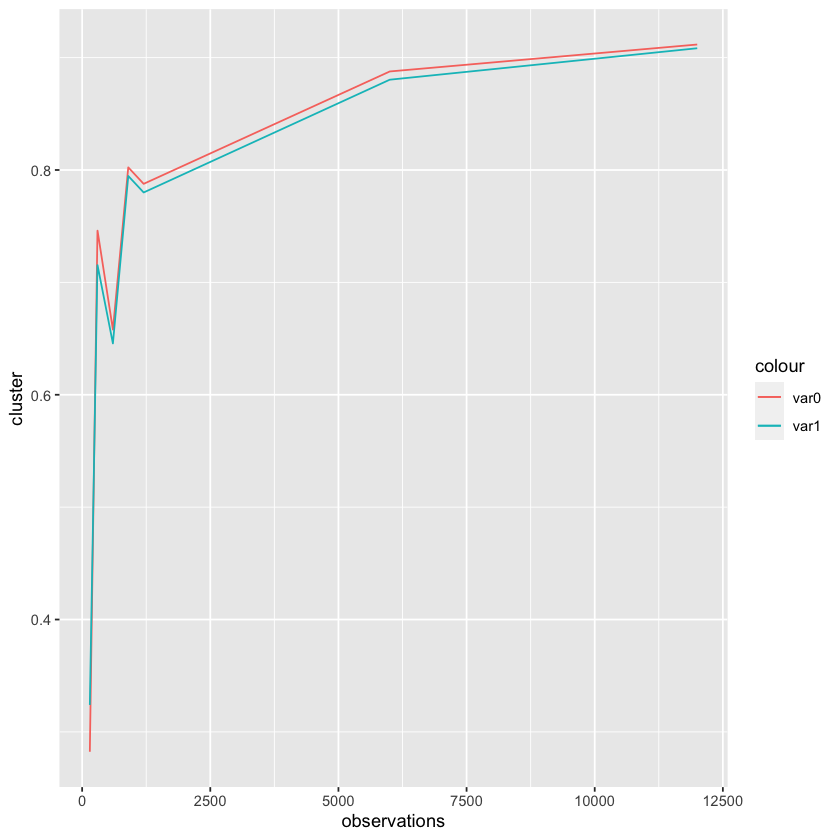

In [91]:
ggplot(dataf, aes(observations)) + 
  geom_line(aes(y = cluster, colour = "var0"))+
  geom_line(aes(y=nocluster, colour="var1"))

allocation_sequence<-seq(min(test_data$simulation_data$totalallocation), max(test_data$simulation_data$totalallocation),
                        500)
payment_sequence<-seq(min(test_data$simulation_data$zkadesbengkoktotal), max(test_data$simulation_data$zkadesbengkoktotal),
                        500)


In [76]:
plot_data<-MSE_function(n_test=9000, n_train=1200, n.trees=500, model_true='medium', model_est='medium')$complete_data

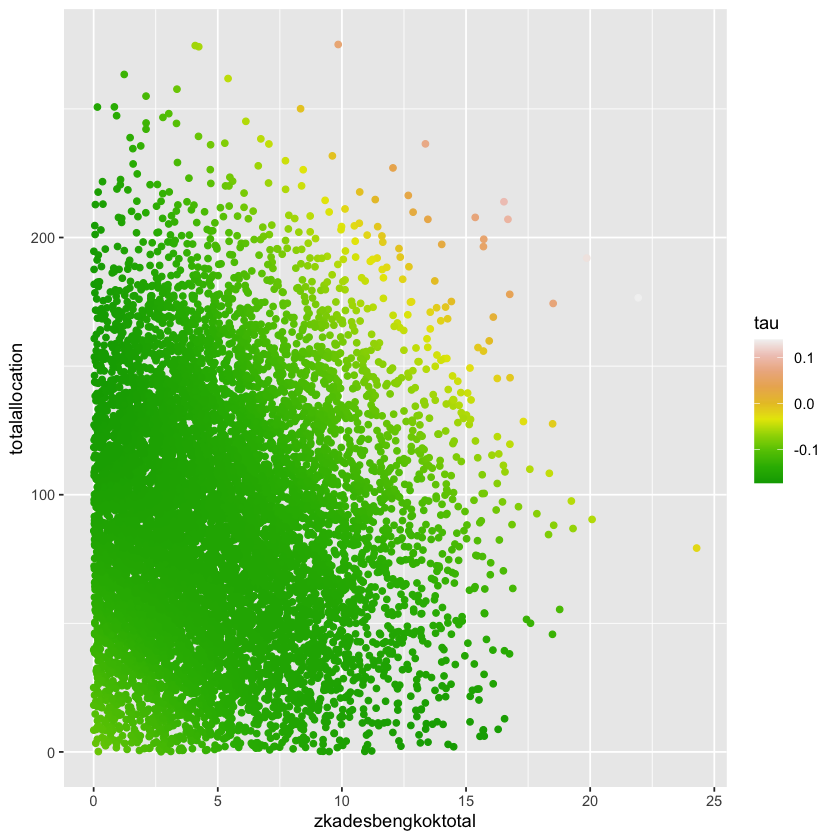

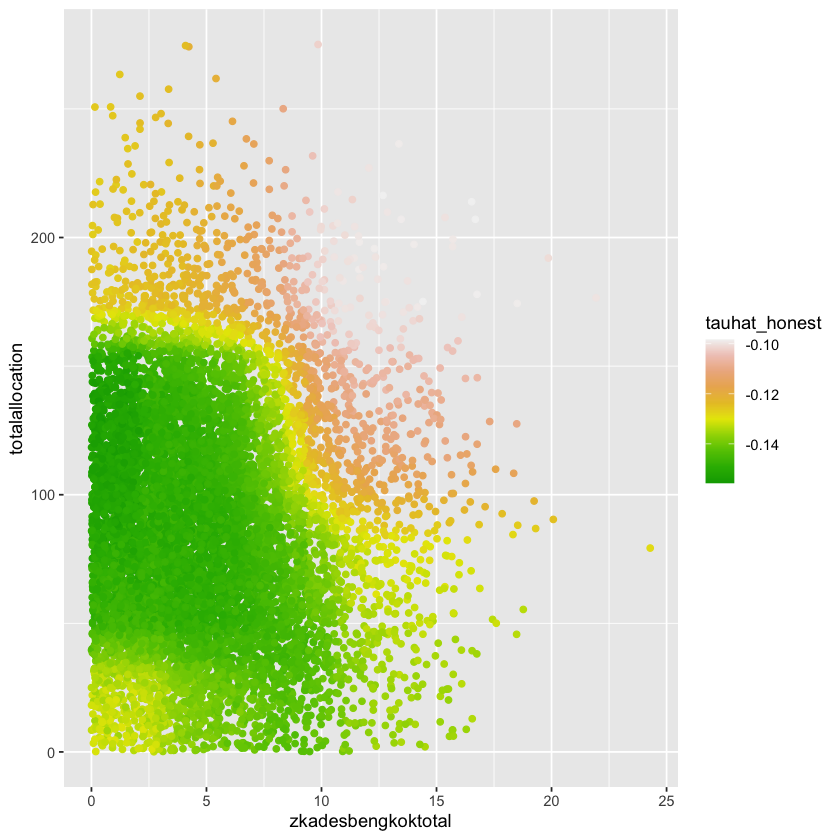

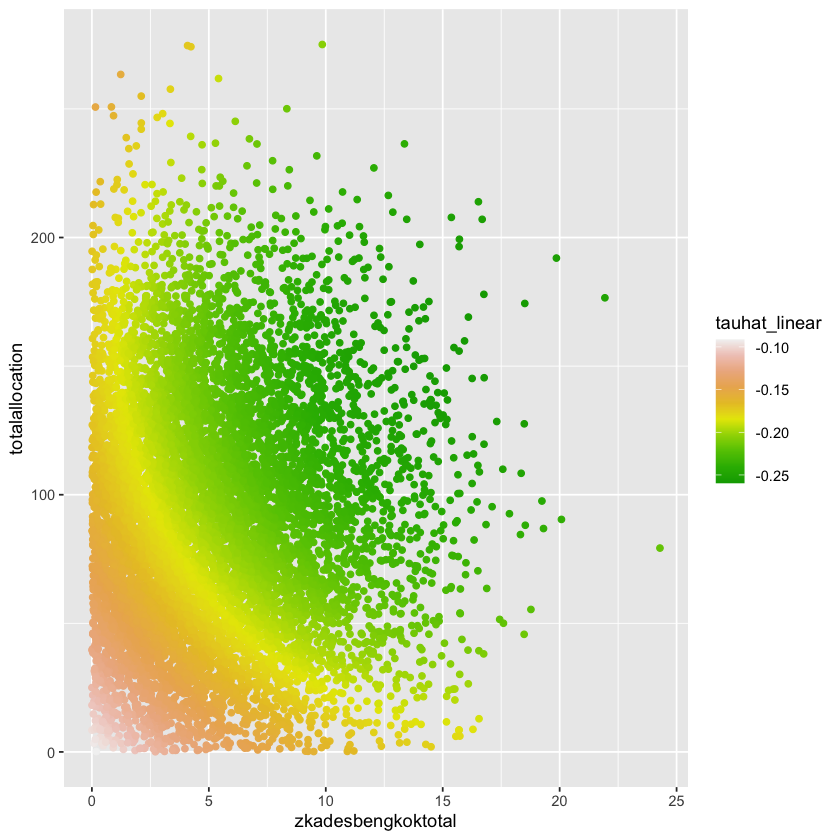

In [77]:
ggplot(plot_data, aes(zkadesbengkoktotal, totalallocation))+
    geom_point(aes(colour = tau)) +
      scale_colour_gradientn(colours = terrain.colors(10))

ggplot(plot_data, aes(zkadesbengkoktotal, totalallocation))+
    geom_point(aes(colour = tauhat_honest)) +
      scale_colour_gradientn(colours = terrain.colors(10))

ggplot(plot_data, aes(zkadesbengkoktotal, totalallocation))+
    geom_point(aes(colour = tauhat_linear)) +
      scale_colour_gradientn(colours = terrain.colors(10))

In [ ]:
rbinom(2,10,0.5)

cf<-causal_forest(X, merged_data$lndiffeall4mainancil, merged_data$audit.x, clusters=merged_data$desaid, min.node.size=30)
?causal_forest
cf
tau.hat = predict(cf)$predictions
tau.hat
ATE = average_treatment_effect(cf)
ATE
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))
a<-round(merged_data$totalallocation/50)*50
dev.off()
options(device = "RStudioGD")
boxplot(tau.hat ~ merged_data$podeszhill, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpercentpoorpra), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpop), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ a, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ merged_data$zkadesedyears, xlab = "X1", ylab = "estimated CATE")

# Variables

Y: Major items in roads and ancilliary projects

W: Audit Treatment (increasing probability of external government audit from 4 to 100 percent)

X1: Village Population (in 1,000)
X2: Mosques per 1,000 population
X3: Total budget (in rp. million)
X4: Number subprojects
X5: Percent household poor
X6: Distance to subdistrict
X7: Village head education
X8: Village head salary (hectares)
X9: Mountainous dummy

In [ ]:
install.packages("truncnorm")
library(truncnorm)

In [ ]:
as.list(enumerate(rnorm(5)))

In [ ]:
X<-rtmvnorm(n=100, mean = rep(0, 3), sigma = diag(3), lower=rep(-Inf, length = 3), upper=rep(Inf, length = 3))

In [ ]:
X

In [ ]:
merged_data<-merge(randomization_data, road_data, by="desaid")

merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)
X=cbind(merged_data$zpop, merged_data$totalmesjid, merged_data$totalallocation, merged_data$z4RABnumsubproj, merged_data$zpercentpoorpra, merged_data$zdistancekec,
        merged_data$zkadesedyears, merged_data$zkadesage, merged_data$zkadesbengkoktotal, merged_data$podeszhill)
cf<-causal_forest(X, merged_data$lndiffeall4mainancil, merged_data$audit.x, clusters=merged_data$desaid, min.node.size=30)


tau.hat = predict(cf)$predictions


#paste("95% CI for the ATE:", round(ATE[1], 3),
#      "+/-", round(qnorm(0.975) * ATE[2], 3))
a<-round(merged_data$totalallocation/50)*50
indep_vars<-c("zpop", "totalmesjid", "totalallocation", "z4RABnumsubproj", "zpercentpoorpra", "zdistancekec", "zkadesedyears", "zkadesage", "zkadesbengkoktotal")





ols<-lm(lndiffeall4mainancil~totalallocation+audit.x*zkadesbengkoktotal, data=merged_data)
coeftest(ols, vcov.=vcovHC(ols, cluster="kecnum"))

audit.x:zpop=-0.013 not sig
audit.x:totalallocation  0.00129030 sig 5
audit.x:zpercentpoorpra -0.1284986 not sig
audit.x:zkadesbengkoktotal -0.0085617 not sig

zkadesage          -0.00342802
zkadesedyears      -0.00570659
totalallocation     0.00067749
totalmesjid        -0.03397987
z4RABnumsubproj    -0.02843929 

In [ ]:
boxplot(tau.hat ~ merged_data$podeszhill, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpercentpoorpra), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpop), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ a, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ merged_data$zkadesedyears, xlab = "X1", ylab = "estimated CATE")

Questions:

DGP heuristically or actually calculate means, standard deviations, correlations, correlations within subdistricts?
Truncated normal?

Use probit model to predict whether mountainous or not?

Changing number of trees and sample size to vary honest and adaptive?

In [ ]:
lower=c(1,2,3)
upper=c(10,11, 12)
this=c(12,6,9)
sum(lower<=this&this<=upper)

In [ ]:
X_train=matrix(nrow=900, ncol=10, rnorm(10, 1))
X_test=matrix(nrow=900, ncol=10, rnorm(10, 1))
W=rbinom(900, 1, p=0.5)
tau=0.1*X_train[,1]
Y=tau+rnorm(n=900, 0, 1)
cf_honest<-causal_forest(W=W, X=X_train, Y=Y)
cf_adaptive<-causal_forest(W=W, X=X_train, Y=Y, honesty=FALSE)
honest<-predict(X=X_test, cf_honest, estimate.variance=TRUE)
tauhat_honest<-honest$predictions
var_honest<-honest$variance.estimates

adaptive<-predict(X=X_test, cf_adaptive, estimate.variance=TRUE)
tauhat_adaptive<-adaptive$predictions
var_adaptive<-adaptive$variance.estimates

#predict(cf, X_test, estimate.variance=TRUE)$variance.estimates


In [ ]:
(mse_hon<-mean((tauhat_honest-tau)^2))
(mse_ada<-mean((tauhat_adaptive-tau)^2))

mean(tauhat_honest-2*sqrt(var_honest)<=tau&tau<=tauhat_honest+2*sqrt(var_honest))
mean(tauhat_adaptive-2*sqrt(var_adaptive)<=tau&tau<=tauhat_adaptive+2*sqrt(var_adaptive))

In [ ]:
c(a,b)<-c(1,2)

To do so, we use the infinitesimal jackknife for random forests developed by Efron (2014) and Wager, Hastie, and Efron (2014), based on the original infinitesimal jackknife procedure of Jaeckel (1972). This method assumes that we have taken the number of trees B to be large enough that the Monte Carlo variability of the forest does not matter; and only measures the randomness in τˆ(x) due to the training sample.